# Data import & data processing

<!DOCTYPE html>
<html>
<head>
    <title>Project Progress</title>
</head>
<body>
    <h1>Project Progress Overview</h1>
    <ul>
        <li><strong>Data Collection</strong>: A European index from 1998 to 2023, inflation, output gap, and main refinancing rate in Europe [?]</li>
        <li><strong>Scrapping and Data Cleaning and Consolidation</strong> [Done]</li>
        <li><strong>Calculating the Jaccard Similarity</strong> [Done] - Assigned to Gwen for improvement</li>
        <li><strong>Calculating the Pessimism Score for Every Period</strong> [Done]</li>
        <li><strong>Pessimism Score Improvement Using Hugo's Algorithm</strong> - Assigned to Hugo</li>
        <li><strong>Final DataFrame Construction</strong> - Assigned to Charaf</li>
        <li><strong>Calculating the Cumulative Abnormal Returns for the European Index</strong> - Assigned to Gwen</li>
        <li><strong>Regressing the Cumulative Abnormal Returns on Combinations of Pessimism Scores, Similarity, Inflation, Output Gap, and Main Refinancing Rates</strong> - Is this done? If not, assigned to Gwen</li>
        <li><strong>Analysing Non-Linearity in Cumulative Abnormal Returns</strong></li>
        <li><strong>Report Writing</strong></li>
        <li><strong>Preparing Slides for Presentation</strong></li>
    </ul>
</body>
</html>


In [2]:

import pandas as pd
import re
import numpy as np
import os
import time
import requests
from bs4 import BeautifulSoup
import datetime
from tqdm import tqdm
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tqdm import tqdm
from nltk.stem.porter import PorterStemmer
import itertools
import matplotlib.pyplot as plt



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zgcha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zgcha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Web scrapping

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import pandas as pd
import time

# Set up the WebDriver
driver_path = '/path/to/your/webdriver'  # Replace with the path to your WebDriver
driver = webdriver.Chrome(executable_path=driver_path)

# The target URL
url = 'https://www.ecb.europa.eu/press/pressconf/html/index.en.html'

# Open the page with Selenium
driver.get(url)

# Let the page load (wait for a few seconds if needed)
time.sleep(3)

# Get the page source and parse it with BeautifulSoup
soup = BeautifulSoup(driver.page_source, 'html.parser')

# Find all <dt> and <dd> tags which contain the date and the link respectively
dates = soup.find_all('dt', {'isodate': True})
statements = soup.find_all('dd')

# Initialize an empty list to store the data
data = []

# Iterate over the dates and statements
for date, statement in zip(dates, statements):
    # Extract date
    statement_date = date.div.text.strip()

    # Extract the link
    link_tag = statement.find('a')
    if link_tag and 'href' in link_tag.attrs:
        statement_url = 'https://www.ecb.europa.eu' + link_tag['href']

        # Use Selenium to open the statement page
        driver.get(statement_url)
        time.sleep(3)  # Wait for the page to load

        # Parse the opened page
        statement_soup = BeautifulSoup(driver.page_source, 'html.parser')
        # Extract content from the <main> tag
        statement_content = statement_soup.find('main').text.strip() if statement_soup.find('main') else ''

        # Append the data to the list
        data.append({
            'date': statement_date,
            'link': statement_url,
            'content': statement_content
        })

# Close the WebDriver
driver.quit()

# Create a DataFrame
df = pd.DataFrame(data)

# Now df contains the desired data
df.to_csv('final_df.csv')


# Data processing

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Load the dataset
ecb_statements = pd.read_csv('final_df.csv').drop('Date',axis=1)

#ecb_statements['date'] = pd.to_datetime(ecb_statements['date'], format='%d %B %Y')

# The 'date' column will now be in the numeric date format (yyyy-mm-dd)
# Display the DataFrame to verify
ecb_statements.head()
df_conf=ecb_statements.sort_values(by='date')
df_conf

,Unnamed: 0,link,content,date
274,274,https://www.ecb.europa.eu/press/pressconf/1998...,ECB Press conference: Introductory statement\n...,1998-06-09
273,273,https://www.ecb.europa.eu/press/pressconf/1998...,ECB Press conference: Introductory statement\n...,1998-07-08
272,272,https://www.ecb.europa.eu/press/pressconf/1998...,ECB Press conference: Introductory statement\n...,1998-09-01
271,271,https://www.ecb.europa.eu/press/pressconf/1998...,ECB Press conference: Introductory statement\n...,1998-10-13
270,270,https://www.ecb.europa.eu/press/pressconf/1998...,ECB Press conference: Introductory statement\n...,1998-11-03
...,...,...,...,...
4,4,https://www.ecb.europa.eu/press/pressconf/2023...,MONETARY POLICY STATEMENTPRESS CONFERENCEChris...,2023-05-04
3,3,https://www.ecb.europa.eu/press/pressconf/2023...,MONETARY POLICY STATEMENTPRESS CONFERENCEChris...,2023-05-23
2,2,https://www.ecb.europa.eu/press/pressconf/2023...,MONETARY POLICY STATEMENTPRESS CONFERENCEChris...,2023-07-27
1,1,https://www.ecb.europa.eu/press/pressconf/2023...,MONETARY POLICY STATEMENTPRESS CONFERENCEChris...,2023-09-14


In [6]:
df_conf.content[1]

"MONETARY POLICY STATEMENTPRESS CONFERENCEChristine Lagarde, President of the ECB,Luis de Guindos, Vice-President of the ECBFrankfurt am Main, 14 September 2023    Jump to the transcript of the questions and answersGood afternoon, the Vice-President and I welcome you to our press conference.Inflation continues to decline but is still expected to remain too high for too long. We are determined to ensure that inflation returns to our two per cent medium-term target in a timely manner. In order to reinforce progress towards our target, the Governing Council today decided to raise the three key ECB interest rates by 25 basis points.The rate increase today reflects our assessment of the inflation outlook in light of the incoming economic and financial data, the dynamics of underlying inflation, and the strength of monetary policy transmission. The September ECB staff macroeconomic projections for the euro area see average inflation at 5.6 per cent in 2023, 3.2 per cent in 2024 and 2.1 per c

 # Content cleaning
 

In [9]:
# Assuming df_conf is your DataFrame

# 1. Remove "Jump to the transcript" phrases
df_conf['content'] = df_conf['content'].str.replace("Jump to the transcript", "", regex=False)

# 2. Apply the text_cleansing function to each row in the 'content' column
def text_cleansing(text):
    index = text.find("answers")
    if index != -1:
        text_cleaned = text[index + len("answers"):].strip()
        split_phrases = [
            "We are now ready to take your questions.",
            "We are now at your disposal for questions.",
            "We are now at your disposal, should you have any questions.",
            "Transcript of the questions asked and the answers given by",
            "We stand ready to answer any questions you may have.",
            "CONTACT",
            "You may also be interested",
            "Related topics"
        ]
        for phrase in split_phrases:
            text_cleaned = text_cleaned.split(phrase)[0]
        return text_cleaned
    else:
        return text

df_conf['content'] = df_conf['content'].apply(text_cleansing)

# 3. Set the 'date' column as the index of the DataFrame
df_conf = df_conf.set_index('date')

# Additional operation (if required):
# Drop an entry without text content (if applicable)
# df_conf = df_conf.drop(index=[index_of_unnecessary_entry])


In [15]:
df_conf.content[-1]

'Good afternoon, the Vice-President and I welcome you to our press conference. I would like to thank Governor Stournaras for his kind hospitality and express our special gratitude to his staff for the excellent organisation of today’s meeting of the Governing Council.The Governing Council today decided to keep the three key ECB interest rates unchanged. The incoming information has broadly confirmed our previous assessment of the medium-term inflation outlook. Inflation is still expected to stay too high for too long, and domestic price pressures remain strong. At the same time, inflation dropped markedly in September, including due to strong base effects, and most measures of underlying inflation have continued to ease. Our past interest rate increases continue to be transmitted forcefully into financing conditions. This is increasingly dampening demand and thereby helps push down inflation.We are determined to ensure that inflation returns to our two per cent medium-term target in a 

In [16]:

stops = list(stopwords.words('english'))


def clean(x):
    x = x.lower()
    x = re.sub(r'[^\w\s]', '', x)
    x = word_tokenize(x)
    x = [w for w in x if w not in stops]
    return(x)

df_conf['transform'] = [clean(i) for i in (df_conf['content'])]

stemmer = PorterStemmer()
df_conf['stem'] = df_conf['transform'].apply(lambda x: [stemmer.stem(token) for token in x])
df_conf

,Unnamed: 0,link,content,transform,stem
date,,,,,
1998-06-09,274,https://www.ecb.europa.eu/press/pressconf/1998...,"Good afternoon, the Vice-President and I welco...","[good, afternoon, vicepresident, welcome, pres...","[good, afternoon, vicepresid, welcom, press, c..."
1998-07-08,273,https://www.ecb.europa.eu/press/pressconf/1998...,"Good afternoon, the Vice-President and I welco...","[good, afternoon, vicepresident, welcome, pres...","[good, afternoon, vicepresid, welcom, press, c..."
1998-09-01,272,https://www.ecb.europa.eu/press/pressconf/1998...,"Good afternoon, the Vice-President and I welco...","[good, afternoon, vicepresident, welcome, pres...","[good, afternoon, vicepresid, welcom, press, c..."
1998-10-13,271,https://www.ecb.europa.eu/press/pressconf/1998...,"Good afternoon, the Vice-President and I welco...","[good, afternoon, vicepresident, welcome, pres...","[good, afternoon, vicepresid, welcom, press, c..."
1998-11-03,270,https://www.ecb.europa.eu/press/pressconf/1998...,"Good afternoon, the Vice-President and I welco...","[good, afternoon, vicepresident, welcome, pres...","[good, afternoon, vicepresid, welcom, press, c..."
...,...,...,...,...,...
2023-05-04,4,https://www.ecb.europa.eu/press/pressconf/2023...,"Good afternoon, the Vice-President and I welco...","[good, afternoon, vicepresident, welcome, pres...","[good, afternoon, vicepresid, welcom, press, c..."
2023-05-23,3,https://www.ecb.europa.eu/press/pressconf/2023...,"Good afternoon, the Vice-President and I welco...","[good, afternoon, vicepresident, welcome, pres...","[good, afternoon, vicepresid, welcom, press, c..."
2023-07-27,2,https://www.ecb.europa.eu/press/pressconf/2023...,"Good afternoon, the Vice-President and I welco...","[good, afternoon, vicepresident, welcome, pres...","[good, afternoon, vicepresid, welcom, press, c..."


# SIMILARITY MEASURE

In [5]:

def jaccard_similarity(set_1, set_2):
    # Convert the sets to lists
    list_1 = list(set_1)
    list_2 = list(set_2)

    # Find the intersection of the lists
    intersection = len(set(list_1).intersection(list_2))

    # Find the union of the lists
    union = len(set(list_1).union(list_2))

    # Calculate the Jaccard similarity score
    jaccard_similarity = intersection / union
    return jaccard_similarity

# applying similarity to the data
jaccard_sim = []
#Insert NaN for the first element of the list
jaccard_sim.insert(0, np.NaN)

for i in range(len(df_conf['stem'])):
    try:
        jaccard_sim.append(jaccard_similarity(df_conf['stem'][i], df_conf['stem'][i+1]))
    except:
        print(i)
        pass

df_conf.reset_index(inplace=True)
df_conf['jaccard_similarity'] = jaccard_sim
df_conf

274


,date,Unnamed: 0,link,content,transform,stem,jaccard_similarity
0,1998-06-09,274,https://www.ecb.europa.eu/press/pressconf/1998...,MONETARY POLICY STATEMENTPRESS CONFERENCEChris...,"[monetary, policy, statementpress, conferencec...","[monetari, polici, statementpress, conferencec...",NaN
1,1998-07-08,273,https://www.ecb.europa.eu/press/pressconf/1998...,MONETARY POLICY STATEMENTPRESS CONFERENCEChris...,"[monetary, policy, statementpress, conferencec...","[monetari, polici, statementpress, conferencec...",0.436981
2,1998-09-01,272,https://www.ecb.europa.eu/press/pressconf/1998...,MONETARY POLICY STATEMENTPRESS CONFERENCEChris...,"[monetary, policy, statementpress, conferencec...","[monetari, polici, statementpress, conferencec...",0.452153
3,1998-10-13,271,https://www.ecb.europa.eu/press/pressconf/1998...,MONETARY POLICY STATEMENTPRESS CONFERENCEChris...,"[monetary, policy, statementpress, conferencec...","[monetari, polici, statementpress, conferencec...",0.447518
4,1998-11-03,270,https://www.ecb.europa.eu/press/pressconf/1998...,MONETARY POLICY STATEMENTPRESS CONFERENCEChris...,"[monetary, policy, statementpress, conferencec...","[monetari, polici, statementpress, conferencec...",0.457980
...,...,...,...,...,...,...,...
270,2023-05-04,4,https://www.ecb.europa.eu/press/pressconf/2023...,MONETARY POLICY STATEMENTPRESS CONFERENCEChris...,"[monetary, policy, statementpress, conferencec...","[monetari, polici, statementpress, conferencec...",0.492620
271,2023-05-23,3,https://www.ecb.europa.eu/press/pressconf/2023...,MONETARY POLICY STATEMENTPRESS CONFERENCEChris...,"[monetary, policy, statementpress, conferencec...","[monetari, polici, statementpress, conferencec...",0.519481
272,2023-07-27,2,https://www.ecb.europa.eu/press/pressconf/2023...,MONETARY POLICY STATEMENTPRESS CONFERENCEChris...,"[monetary, policy, statementpress, conferencec...","[monetari, polici, statementpress, conferencec...",0.522124
273,2023-09-14,1,https://www.ecb.europa.eu/press/pressconf/2023...,MONETARY POLICY STATEMENTPRESS CONFERENCEChris...,"[monetary, policy, statementpress, conferencec...","[monetari, polici, statementpress, conferencec...",0.532348


# Pessimism Score


In [6]:

df_conf['pessimism'] = np.NaN
df_conf['pessimism_2'] = np.NaN
# for pessimism we didn't lemmatize because LM has all variants of a word
#retrieve the LM database
lm = pd.read_csv('Loughran-McDonald_MasterDictionary_1993-2021.csv')
lm["Word"] = lm["Word"].astype(str)

neg_list = list(lm[lm["Negative"] !=0]["Word"])
pos_list = list(lm[lm["Positive"] !=0]["Word"])

neg_list = [x.lower() for x in neg_list]
pos_list = [x.lower() for x in pos_list]

for i in tqdm(range(len(df_conf))):
    content = df_conf['transform'][i]
    neg_words = []
    pos_words = []
    for token in content:
        if token in neg_list:
            neg_words.append(token)
        if token in pos_list:
            pos_words.append(token)

    df_conf.loc[i, 'pessimism']  = (len(neg_words) - len(pos_words)) / (len(neg_words) + len(pos_words)+1**-10)
    df_conf.loc[i, 'pessimism_2'] = (len(neg_words) - len(pos_words)) / len(content)
df_conf

100%|████████████████████████████████████████████████████████████████████████████████| 275/275 [00:36<00:00,  7.51it/s]


,date,Unnamed: 0,link,content,transform,stem,jaccard_similarity,pessimism,pessimism_2
0,1998-06-09,274,https://www.ecb.europa.eu/press/pressconf/1998...,MONETARY POLICY STATEMENTPRESS CONFERENCEChris...,"[monetary, policy, statementpress, conferencec...","[monetari, polici, statementpress, conferencec...",NaN,0.400000,0.022017
1,1998-07-08,273,https://www.ecb.europa.eu/press/pressconf/1998...,MONETARY POLICY STATEMENTPRESS CONFERENCEChris...,"[monetary, policy, statementpress, conferencec...","[monetari, polici, statementpress, conferencec...",0.436981,0.335165,0.020192
2,1998-09-01,272,https://www.ecb.europa.eu/press/pressconf/1998...,MONETARY POLICY STATEMENTPRESS CONFERENCEChris...,"[monetary, policy, statementpress, conferencec...","[monetari, polici, statementpress, conferencec...",0.452153,0.384106,0.019661
3,1998-10-13,271,https://www.ecb.europa.eu/press/pressconf/1998...,MONETARY POLICY STATEMENTPRESS CONFERENCEChris...,"[monetary, policy, statementpress, conferencec...","[monetari, polici, statementpress, conferencec...",0.447518,0.308219,0.015801
4,1998-11-03,270,https://www.ecb.europa.eu/press/pressconf/1998...,MONETARY POLICY STATEMENTPRESS CONFERENCEChris...,"[monetary, policy, statementpress, conferencec...","[monetari, polici, statementpress, conferencec...",0.457980,0.344371,0.016169
...,...,...,...,...,...,...,...,...,...
270,2023-05-04,4,https://www.ecb.europa.eu/press/pressconf/2023...,MONETARY POLICY STATEMENTPRESS CONFERENCEChris...,"[monetary, policy, statementpress, conferencec...","[monetari, polici, statementpress, conferencec...",0.492620,0.187500,0.009989
271,2023-05-23,3,https://www.ecb.europa.eu/press/pressconf/2023...,MONETARY POLICY STATEMENTPRESS CONFERENCEChris...,"[monetary, policy, statementpress, conferencec...","[monetari, polici, statementpress, conferencec...",0.519481,0.245614,0.013346
272,2023-07-27,2,https://www.ecb.europa.eu/press/pressconf/2023...,MONETARY POLICY STATEMENTPRESS CONFERENCEChris...,"[monetary, policy, statementpress, conferencec...","[monetari, polici, statementpress, conferencec...",0.522124,0.266667,0.012618
273,2023-09-14,1,https://www.ecb.europa.eu/press/pressconf/2023...,MONETARY POLICY STATEMENTPRESS CONFERENCEChris...,"[monetary, policy, statementpress, conferencec...","[monetari, polici, statementpress, conferencec...",0.532348,0.326531,0.016684


# Plotting


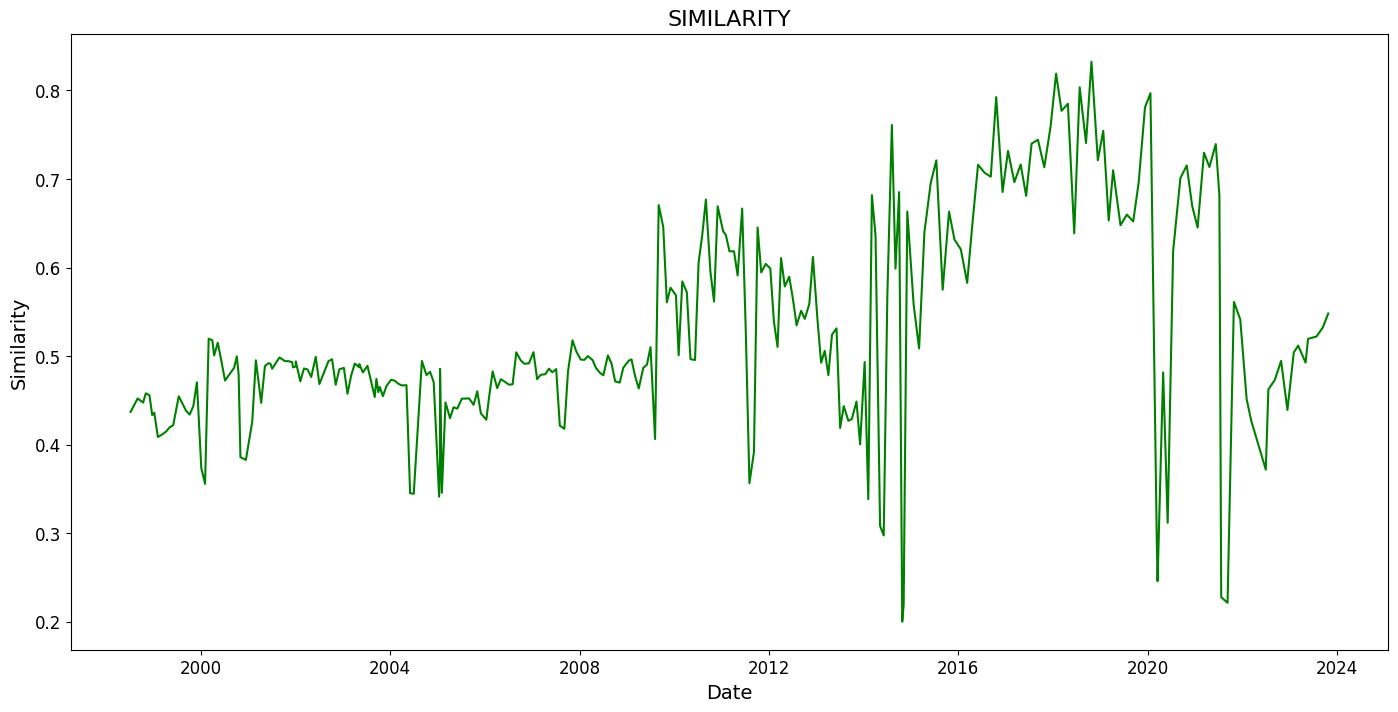

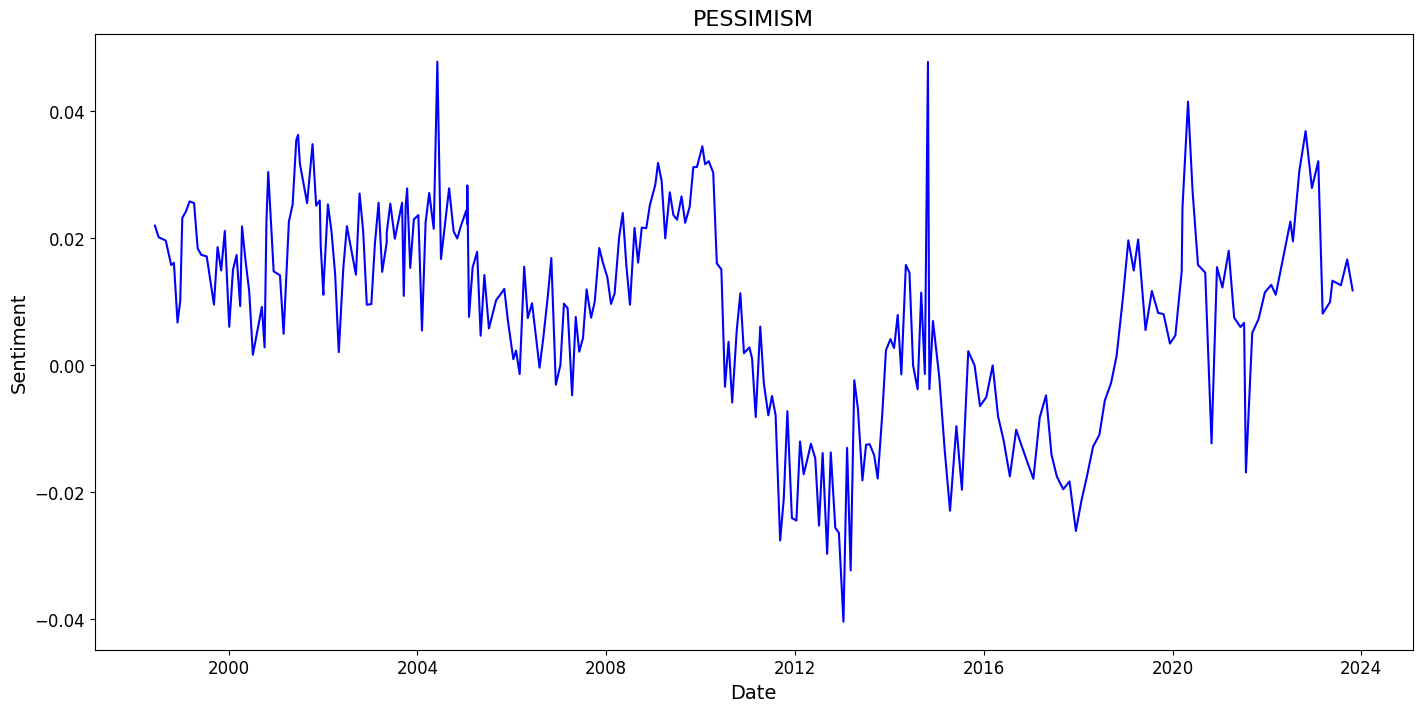

In [7]:
# plotting function to be applied to every measure
df_conf.rename(columns={'date': 'Date'}, inplace=True)
def plot_result(df, x, y, title, xlabel, ylabel, color):
    # Create a figure and set the size
    plt.figure(figsize=(17, 8))

    # Plot the specified columns using the specified color
    plt.plot(df[x], df[y], color=color)

    # Add a title and axis labels
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    #plt.grid()

    # Show the plot
    plt.show()


# Convert 'date' column to datetime format in date_2 just for visualisation
df_conf['date_2'] = pd.to_datetime(df_conf['Date'])


#plot  similarity
plot_result(df_conf, 'date_2', 'jaccard_similarity', 'SIMILARITY', 'Date', 'Similarity', 'green')
# plot sentiment_2 which the one used in the paper
plot_result(df_conf, 'date_2', 'pessimism_2', 'PESSIMISM', 'Date', 'Sentiment', 'blue')
#plot pessimism 1
#plot_result(df_conf, 'date_2', 'pessimism', 'PESSIMISM', 'Date', 'Sentiment', 'teal')


In [8]:
df_conf.to_csv('transformed_dataset_hugo.csv')

In [9]:
from datetime import datetime

def days_since_1999(date):
    start_date = datetime(1999, 1, 1)
    end_date = date
    return (end_date - start_date).days


dt = [days_since_1999(i) for i in df_conf['date_2']]
df_conf['diff'] = dt


reg_df = df_conf[['Date', 'jaccard_similarity', 'pessimism', 'pessimism_2', 'diff']]
reg_df = reg_df.rename(columns={'date': 'Date'})

reg_df

,Date,jaccard_similarity,pessimism,pessimism_2,diff
0,1998-06-09,NaN,0.400000,0.022017,-206
1,1998-07-08,0.436981,0.335165,0.020192,-177
2,1998-09-01,0.452153,0.384106,0.019661,-122
3,1998-10-13,0.447518,0.308219,0.015801,-80
4,1998-11-03,0.457980,0.344371,0.016169,-59
...,...,...,...,...,...
270,2023-05-04,0.492620,0.187500,0.009989,8889
271,2023-05-23,0.519481,0.245614,0.013346,8908
272,2023-07-27,0.522124,0.266667,0.012618,8973
273,2023-09-14,0.532348,0.326531,0.016684,9022


In [17]:
df_eurostock = pd.read_excel('MSCI EURO.xlsx')[['Date','Price']].sort_values(by='Date')
df_eurostock['Date'] = pd.to_datetime(df_eurostock['Date'], format='%d/%m/%Y')
df_eurostock['last'] = list(map(lambda x: np.log(x), df_eurostock['Price']))
df_eurostock['pct_change'] = np.NaN
df_eurostock['pct_change'] = df_eurostock['last'].diff(1)

In [18]:
df_eurostock.tail(40)
df_eurostock.dropna(inplace=True)
df_eurostock_to_np = df_eurostock['pct_change'].to_numpy()
df_eurostock

,Date,Price,last,pct_change
7011,1997-01-01,549.766000,6.309493,0.000000
7010,1997-01-02,540.659000,6.292789,-0.016704
7009,1997-01-03,545.842000,6.302330,0.009541
7008,1997-01-06,549.316000,6.308674,0.006344
7007,1997-01-07,549.231000,6.308519,-0.000155
...,...,...,...,...
4,2023-11-10,1371.655134,7.223773,-0.007365
3,2023-11-13,1381.763593,7.231116,0.007343
2,2023-11-14,1402.400629,7.245941,0.014825
1,2023-11-15,1409.783286,7.251191,0.005250


# GETTING EUROSTOCK DATA

In [19]:
#%%******************************************************



window_value_abnormal_return = {}
window_value_car = {}

df_eurostock['cumulate'] = np.NaN
df_eurostock['CAR'] = np.NaN

 
for n in (range(len(df_eurostock_to_np))):
    x = df_eurostock_to_np[n-251:n-50]
    window_value_abnormal_return[n] = 1/201*(np.sum(x))
liste_cumu = list(window_value_abnormal_return.values())
df_eurostock.cumulate = liste_cumu
df_eurostock['abnormal_return'] = np.NaN

 
df_eurostock['abnormal_return'] = df_eurostock['pct_change'] - df_eurostock['cumulate']
df_eurostock_car_to_np = df_eurostock['abnormal_return'].to_numpy()

#  Computation of cumulative abnormal returns via the same method used above
for n in (range(len(df_eurostock_car_to_np))):
    x = df_eurostock_car_to_np[n-6:n+5]
    window_value_car[n] = np.sum(x)
liste_car= list(window_value_car.values())
df_eurostock.CAR = liste_car

df_eurostock['Date'] = df_eurostock['Date'].astype('datetime64[ns]')
df_eurostock.rename(columns = {'last':'eurostock_last','pct_change':'eurostock_pct_change','cumulate':'eurostock_cumulate',
                               'abnormal_return':'eurostock_abnormal_return', 'CAR':'eurostock_CAR'}, inplace = True)

df_eurostock['Date'] = pd.to_datetime(df_eurostock['Date'], format='%d/%m/%Y')

# retrieving Eurostock CAR results in a new df
df_eurostock_final = df_eurostock.loc[:,['Date', 'eurostock_cumulate', 'eurostock_abnormal_return', 'eurostock_CAR']]
df_eurostock_final

,Date,eurostock_cumulate,eurostock_abnormal_return,eurostock_CAR
7011,1997-01-01,0.000309,-0.000309,0.000000
7010,1997-01-02,0.000297,-0.017001,0.000000
7009,1997-01-03,0.000323,0.009218,0.000000
7008,1997-01-06,0.000333,0.006011,0.000000
7007,1997-01-07,0.000338,-0.000493,0.000000
...,...,...,...,...
4,2023-11-10,0.000421,-0.007787,0.044410
3,2023-11-13,0.000381,0.006962,0.026850
2,2023-11-14,0.000370,0.014455,0.024388
1,2023-11-15,0.000392,0.004858,0.029241


In [21]:
df_hicp = pd.read_excel('Inflation & interest.xlsx')
df_hicp = df_hicp.rename(columns={'Unnamed: 0':'Date'})
df_hicp=df_hicp[['Date','Inflation']].sort_values(by='Date')
df_hicp.head()
df_hicp['Date'] = pd.to_datetime(df_hicp['Date'], format='%m/%Y').dt.strftime('%Y-%m')
df_hicp.Date = df_hicp.Date.apply(lambda x: str(x).replace(x, x+'-01'))
df_hicp['Date'] = df_hicp['Date'].astype('datetime64[ns]')

In [22]:
df_hicp=df_hicp.sort_values(by='Date')
df_hicp

,Date,Inflation
99,1998-12-01,1.358338
98,1999-03-01,0.761581
97,1999-06-01,0.971927
96,1999-09-01,1.167831
95,1999-12-01,1.646059
...,...,...
4,2022-09-01,9.447888
3,2022-12-01,10.058137
2,2023-03-01,8.936144
1,2023-06-01,6.913111


In [36]:
import pandas as pd

# Function to convert quarter format to datetime
def parse_quarter(string):
    year, quarter = string.split('-')
    month = (int(quarter[1]) - 1) * 3 + 1  # Convert quarter to start month
    return f'{year}-{month:02d}-01'  # Return the first day of the start month

df_ogap = pd.read_csv('Q GDP.csv')
df_ogap = df_ogap.rename(columns={'TIME': 'Date'})
df_ogap['Date'] = df_ogap['Date'].apply(parse_quarter)  # Apply custom parsing function
df_ogap['Date'] = pd.to_datetime(df_ogap['Date'])  # Convert to datetime
df_ogap = df_ogap.set_index('Date')
df_ogap_daily = df_ogap['Gdp growth'].resample('D').mean()
df_ogap_daily = pd.DataFrame(df_ogap_daily.interpolate())



In [35]:
df_ogap_daily=df_ogap_daily.sort_values(by='Date')
# convert to YYYY-MM
df_ogap_daily.index = pd.to_datetime(df_ogap_daily.index, format='%Y-%m-%d %H:%M:%S').dt.strftime('%Y-%m')
df_ogap_daily.Date = df_ogap_daily.Date.apply(lambda x: str(x).replace(x, x+'-01'))
df_ogap_daily['Date'] = df_ogap_daily['Date'].astype('datetime64[ns]')

AttributeError: 'DatetimeIndex' object has no attribute 'dt'

In [31]:
df_ogap

,Gdp growth
Date,
1997-01-01,0.617985
1997-04-01,1.286125
1997-07-01,0.930671
1997-10-01,0.965790
1998-01-01,0.436861
...,...
2021-10-01,0.708089
2022-01-01,0.694142
2022-04-01,0.711094


In [37]:
df_ogap_daily

,Gdp growth
Date,
1995-04-01,0.597658
1995-04-02,0.595551
1995-04-03,0.593445
1995-04-04,0.591338
1995-04-05,0.589231
...,...
2022-09-27,0.055005
2022-09-28,0.050964
2022-09-29,0.046924


# Merging all datasets 

In [38]:
 
## Convert monthly to daily for mro
from datetime import datetime
#import monthly and cleaning date columns
df_mro = pd.read_excel('Inflation & interest.xlsx')
df_mro = df_mro.rename(columns={'Unnamed: 0':'Date'})
# Convert the 'Date' column to a datetime format

# Append a default day to each date string and then convert to datetime
df_mro['Date'] = pd.to_datetime(df_mro['Date'].apply(lambda x: str(x) + '-01'), format='%m/%Y-%d')

# Set the 'Date' column as the index
df_mro = df_mro.set_index('Date')

# Resample and interpolate
df_mro_daily = df_mro.resample('D').mean()
df_mro_daily = df_mro_daily.interpolate()

# Reset the index and keep 'Date' as a column


df_mro['Rate'] = df_mro['LTR INT RATE'].astype(float)

#Interpolation to get daily MRO


In [39]:
df_mro_daily

,Inflation,LTR INT RATE
Date,,
1998-12-01,1.358338,4.278732
1998-12-02,1.351708,4.276394
1998-12-03,1.345077,4.274057
1998-12-04,1.338446,4.271719
1998-12-05,1.331816,4.269382
...,...,...
2023-08-28,5.476246,3.394072
2023-08-29,5.459918,3.395730
2023-08-30,5.443590,3.397387


In [40]:
## Create date column and convert it to dataframe
from datetime import timedelta, date

def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

date_ = []
start_dt = date(1998, 12, 1)
end_dt = date(2022, 10, 1)
for dt in daterange(start_dt, end_dt):
    date_.append(dt.strftime("%Y-%m-%d"))
df_date = pd.DataFrame(date_, columns=['Date'])
df_date['Date'] = df_date['Date'].astype('datetime64[ns]')

In [42]:
df_date

,Date
0,1998-12-01
1,1998-12-02
2,1998-12-03
3,1998-12-04
4,1998-12-05
...,...
8701,2022-09-27
8702,2022-09-28
8703,2022-09-29
8704,2022-09-30


In [43]:
df_mro_daily=df_mro_daily
df_mro_daily

,Inflation,LTR INT RATE
Date,,
1998-12-01,1.358338,4.278732
1998-12-02,1.351708,4.276394
1998-12-03,1.345077,4.274057
1998-12-04,1.338446,4.271719
1998-12-05,1.331816,4.269382
...,...,...
2023-08-28,5.476246,3.394072
2023-08-29,5.459918,3.395730
2023-08-30,5.443590,3.397387


In [44]:
import warnings
warnings.filterwarnings("ignore")

## join date col & reg_df
df_not_clean = pd.merge(df_date,df_eurostock_final,how='left',on=['Date'])
df_not_clean_2 = pd.merge(df_not_clean,df_ogap_daily,how='left',on=['Date'])
df_not_clean_3 = pd.merge(df_not_clean_2,df_mro_daily,how='left',on=['Date'])

df_conf.rename(columns={'date':'Date'}, inplace=True)
df_conf['Date'] = df_conf['Date'].astype('datetime64[ns]')

df_final_not_clean = pd.merge(df_not_clean_3,df_conf,how='left',on=['Date'])

df_final_not_clean.set_index('Date', inplace=True)
df_final_not_clean.dropna(axis = 0, how = 'all', inplace = True)
df_final_not_clean.reset_index(inplace=True)

# Interpolate our variables with a daily granularity
df_final_not_clean.HICP = df_final_not_clean['Inflation'].interpolate()
df_final_not_clean.output_gap = df_final_not_clean['Gdp growth'].interpolate()
df_final_not_clean.mro = df_final_not_clean['LTR INT RATE'].interpolate()

df_final_not_clean.dropna(subset= ['link','Unnamed: 0'], inplace=True)

#df_final_not_clean = df_final_not_clean [['Date','jaccard_similarity','pessimism','pessimism_2','eurostock_cumulate','eurostock_abnormal_return', 'eurostock_CAR', 'Inflation', 'Gdp growth', 'mro', 'diff']]
df_final_not_clean = df_final_not_clean [['Date', 'eurostock_cumulate', 'eurostock_abnormal_return',
       'eurostock_CAR', 'Inflation', 'Gdp growth', 'LTR INT RATE',

       'jaccard_similarity', 'pessimism', 'pessimism_2', 'date_2', 'diff']]
df_final_not_clean.drop_duplicates(subset=['jaccard_similarity','diff'], inplace=True)

#Calculating MRO returns
df_final_not_clean['change_MRO_Rate'] = df_final_not_clean['LTR INT RATE'].diff(1)

#Calculating log for similarity and for Time variable (log_diff)
df_final_not_clean['log_similarity'] = np.log(df_final_not_clean['jaccard_similarity'])
df_final_not_clean['log_diff'] = np.log(df_final_not_clean['diff'].values)

# filling in the remaining missing data w/ latest value
df_final_not_clean.eurostock_cumulate.ffill(inplace=True)
df_final_not_clean.eurostock_abnormal_return.ffill(inplace=True)
df_final_not_clean.eurostock_CAR.ffill(inplace=True)


df_final_not_clean.reset_index(inplace=True, drop=True)
df_final_not_clean = df_final_not_clean[df_final_not_clean.Date > '1998-12-31']
df_final_not_clean

,Date,eurostock_cumulate,eurostock_abnormal_return,eurostock_CAR,Inflation,Gdp growth,LTR INT RATE,jaccard_similarity,pessimism,pessimism_2,date_2,diff,change_MRO_Rate,log_similarity,log_diff
2,1999-01-07,0.000444,-0.016597,-0.025643,1.113005,0.805847,4.192241,0.436155,0.449704,0.023249,1999-01-07,6.0,-0.037401,-0.829758,1.791759
3,1999-02-04,0.000563,-0.001802,-0.033480,0.927347,0.751988,4.126789,0.408617,0.441989,0.024235,1999-02-04,34.0,-0.065452,-0.894977,3.526361
4,1999-03-04,0.000270,0.011865,-0.018795,0.768440,0.698128,4.078243,0.411026,0.485876,0.025834,1999-03-04,62.0,-0.048546,-0.889099,4.127134
5,1999-04-08,-0.000043,0.000567,0.039784,0.848463,0.685648,4.193665,0.414756,0.456989,0.025572,1999-04-08,97.0,0.115423,-0.880064,4.574711
6,1999-05-06,0.000121,-0.003924,-0.017575,0.912481,0.851171,4.286003,0.419636,0.373418,0.018437,1999-05-06,125.0,0.092338,-0.868367,4.828314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,2022-02-03,0.000704,-0.017093,0.026775,5.557810,0.498916,0.850164,0.451670,0.227273,0.012690,2022-02-03,8434.0,0.299891,-0.794804,9.040026
257,2022-03-10,0.000605,-0.028864,0.017972,6.177716,0.556990,1.121812,0.427336,0.242424,0.011127,2022-03-10,8469.0,0.271648,-0.850186,9.044168
258,2022-07-01,-0.000242,0.001715,0.008822,8.565063,0.410590,2.256298,0.371728,0.396552,0.022660,2022-07-01,8582.0,1.134486,-0.989594,9.057422
259,2022-07-21,-0.000642,0.004151,0.038718,8.849845,0.329775,2.320819,0.462457,0.326923,0.019540,2022-07-21,8602.0,0.064520,-0.771201,9.059750


In [45]:
df_final_not_clean.columns

Index(['Date', 'eurostock_cumulate', 'eurostock_abnormal_return',
       'eurostock_CAR', 'Inflation', 'Gdp growth', 'LTR INT RATE',
       'jaccard_similarity', 'pessimism', 'pessimism_2', 'date_2', 'diff',
       'change_MRO_Rate', 'log_similarity', 'log_diff'],
      dtype='object')

# Regression part of original paper (replication of results)

In [95]:
pip install Stargazer

In [46]:
 
import statsmodels.api as sm
from stargazer.stargazer import Stargazer

#Creating a new df with replicate data
df_replicate = df_final_not_clean[df_final_not_clean['Date'] <='2013-12-31']

#exlude first row to avoid na
df_replicate = df_replicate.iloc[2:]

# fit linear regression
def fit_linear_regression(y,x):
    # Add a constant to the predictor variables
    x = sm.add_constant(x)

    # Fit a linear regression model
    model = sm.OLS(y, x).fit()

    # View the model summary
    print(model.summary())

    return model

# REPLICATING REGRESSION RESULTS OF TABLE 3 (in original paper)


In [47]:

fit_linear_regression(df_replicate['log_similarity'].dropna(), df_replicate[['Gdp growth', 'Inflation', 'change_MRO_Rate']].dropna())

fit_linear_regression(df_replicate['log_similarity'].dropna(), df_replicate['log_diff'].dropna())

fit_linear_regression(df_replicate['log_similarity'].dropna(), df_replicate[['log_diff', 'Gdp growth', 'change_MRO_Rate']].dropna())

fit_linear_regression(df_replicate['log_similarity'].dropna(), df_replicate[['Gdp growth', 'Inflation', 'change_MRO_Rate']].dropna())


#calculating CAR absolute value
df_replicate['CAR_abs'] = df_replicate['eurostock_CAR'].abs()
#calculating interaction
df_replicate['interaction'] = df_replicate['pessimism_2'] * df_replicate['jaccard_similarity']

# We didn't include the Time (count) variable below

# REPLICATING REGRESSION RESULTS OF TABLE 4 (in original paper)

fit_linear_regression(df_replicate['CAR_abs'].dropna(), df_replicate[['pessimism_2']].dropna())

fit_linear_regression(df_replicate['CAR_abs'].dropna(), df_replicate[['Gdp growth', 'Inflation', 'change_MRO_Rate']].dropna())

fit_linear_regression(df_replicate['CAR_abs'].dropna(), df_replicate[['interaction']].dropna())

fit_linear_regression(df_replicate['CAR_abs'].dropna(), df_replicate[['interaction', 'Gdp growth', 'Inflation', 'change_MRO_Rate']].dropna())
fit_linear_regression(df_replicate['CAR_abs'].dropna(), df_replicate[['interaction', 'Gdp growth', 'Inflation', 'pessimism_2']].dropna())

                            OLS Regression Results                            
Dep. Variable:         log_similarity   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.487
Date:                Sun, 24 Dec 2023   Prob (F-statistic):              0.220
Time:                        16:09:28   Log-Likelihood:                 113.52
No. Observations:                 181   AIC:                            -219.0
Df Residuals:                     177   BIC:                            -206.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.6822      0.034    -

# Extension part of original paper  


In [50]:
 
df_final = df_final_not_clean.iloc[2:]
 

# Get the last row
last_row = df_final.tail(1)

# Drop the last row
df_final = df_final.drop(last_row.index)

# EXTENDING REGRESSION RESULTS OF TABLE 3

fit_linear_regression(df_final['log_similarity'].dropna(), df_final[['Gdp growth', 'Inflation', 'change_MRO_Rate']].dropna())

fit_linear_regression(df_final['log_similarity'].dropna(), df_final['log_diff'].dropna())

fit_linear_regression(df_final['log_similarity'].dropna(), df_final[['log_diff']].dropna())

fit_linear_regression(df_final['log_similarity'].dropna(), df_final[['Inflation']].dropna())


                            OLS Regression Results                            
Dep. Variable:         log_similarity   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     5.537
Date:                Sun, 24 Dec 2023   Prob (F-statistic):            0.00107
Time:                        16:11:36   Log-Likelihood:                 15.643
No. Observations:                 256   AIC:                            -23.29
Df Residuals:                     252   BIC:                            -9.105
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.5927      0.030    -

# EXTENDING REGRESSION RESULTS OF TABLE 4



In [57]:
#calculating CAR absolute value
df_final['CAR_abs'] = df_final['eurostock_CAR'].abs()
#calculating interaction
df_final['interaction'] = df_final['pessimism_2'] * df_final['jaccard_similarity'] * df_final['Inflation']

# EXTENDING REGRESSION RESULTS OF TABLE 4
print('m1 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
m1 = fit_linear_regression(df_final['CAR_abs'].dropna(), df_final[['pessimism_2']].dropna())
print('m2 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
m2 = fit_linear_regression(df_final['CAR_abs'].dropna(), df_final[['Gdp growth', 'Inflation', 'change_MRO_Rate']].dropna())
print('m3 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
m3 = fit_linear_regression(df_final['CAR_abs'].dropna(), df_final[['interaction']].dropna())
print('m4 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
m4 = fit_linear_regression(df_final['CAR_abs'].dropna(), df_final[['interaction', 'Gdp growth', 'Inflation', 'change_MRO_Rate']].dropna())
print('m5 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
m5 = fit_linear_regression(df_final['CAR_abs'].dropna(), df_final[['interaction', 'Gdp growth', 'Inflation', 'pessimism_2']].dropna())


m1 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                CAR_abs   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9837
Date:                Sun, 24 Dec 2023   Prob (F-statistic):              0.322
Time:                        16:22:17   Log-Likelihood:                 495.81
No. Observations:                 256   AIC:                            -987.6
Df Residuals:                     254   BIC:                            -980.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
     

# *****************************SUMMARY STATISTICS*****************************


In [53]:

def summarize_dataframe(df):
    summary = df.describe().T
    summary = summary[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
    return summary

summary = summarize_dataframe(df_final)
summary

,mean,std,min,25%,50%,75%,max
eurostock_cumulate,0.000034,0.000954,-0.003436,-0.000501,0.000210,0.000682,0.001922
eurostock_abnormal_return,-0.001023,0.017253,-0.134585,-0.007283,0.000685,0.007385,0.055791
eurostock_CAR,0.001903,0.047514,-0.355354,-0.016593,0.006512,0.026864,0.113426
Inflation,1.949590,1.191715,-0.128216,1.277753,2.039145,2.459526,8.849845
Gdp growth,0.404889,1.234110,-9.370405,0.315515,0.534234,0.698503,8.786613
LTR INT RATE,3.369399,1.639145,-0.012688,1.825272,4.006483,4.458785,5.655755
jaccard_similarity,0.527114,0.118457,0.200000,0.467065,0.494091,0.607315,0.832474
pessimism,0.131950,0.286708,-0.645161,-0.047374,0.180461,0.354767,0.753363
pessimism_2,0.008102,0.016136,-0.040369,-0.002750,0.010163,0.020385,0.047836
diff,3982.140625,2381.570909,62.000000,1943.250000,3852.500000,5779.750000,8602.000000


# Capture non-linearity

In [58]:
  
def square_column(df, col):
    df['square_' + col] = df[col] ** 2

#apply var² on Time var (diff)
square_column(df_final, 'diff')

# after ² we apply log
df_final['log_square_diff'] = np.log(df_final['square_diff'])

#apply var² to Similarity
square_column(df_final, 'jaccard_similarity')

#apply var² to INFLATION
square_column(df_final, 'Inflation')
 
def fit_linear_regression_nc(y,x):

    # Fit a linear regression model
    model = sm.OLS(y, x).fit()

    # View the model summary
    print(model.summary())

    return model

# CAPTURING NON-LINEARITY ON SIMILARITY & INFLATION


In [59]:
m1 = fit_linear_regression(df_final['log_similarity'].dropna(), df_final[['log_diff', 'log_square_diff']].dropna())

m2 = fit_linear_regression(df_final['log_similarity'].dropna(), df_final[['square_Inflation', 'Inflation']].dropna())

                            OLS Regression Results                            
Dep. Variable:         log_similarity   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     36.07
Date:                Sun, 24 Dec 2023   Prob (F-statistic):           6.55e-09
Time:                        16:23:23   Log-Likelihood:                 24.470
No. Observations:                 256   AIC:                            -44.94
Df Residuals:                     254   BIC:                            -37.85
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.3918      0.122    -

# CAPTURING NON-LINEARITY ON 


In [56]:



m1 = fit_linear_regression_nc(df_final['CAR_abs'].dropna(), df_final[['jaccard_similarity', 'square_jaccard_similarity']].dropna())
# w/o constant
m2 = fit_linear_regression_nc(df_final['CAR_abs'].dropna(), df_final[['interaction',  'jaccard_similarity', 'square_jaccard_similarity']].dropna())
m3 = fit_linear_regression(df_final['CAR_abs'].dropna(), df_final[['Gdp growth', 'jaccard_similarity', 'square_jaccard_similarity']].dropna())
m4 = fit_linear_regression(df_final['CAR_abs'].dropna(), df_final[['interaction',  'Gdp growth', 'jaccard_similarity', 'square_jaccard_similarity']].dropna())

m5 = fit_linear_regression(df_final['CAR_abs'].dropna(), df_final[['interaction', 'Gdp growth']].dropna())

                                 OLS Regression Results                                
Dep. Variable:                CAR_abs   R-squared (uncentered):                   0.459
Model:                            OLS   Adj. R-squared (uncentered):              0.455
Method:                 Least Squares   F-statistic:                              107.8
Date:                Sun, 24 Dec 2023   Prob (F-statistic):                    1.29e-34
Time:                        16:13:41   Log-Likelihood:                          495.66
No. Observations:                 256   AIC:                                     -987.3
Df Residuals:                     254   BIC:                                     -980.2
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------